# **Random Forest Regression**

In [1]:
import numpy as np
import pandas as pd
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

**Data preparation**

In [3]:
# Cycling data
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))
cycling_data["DATUM_A_CAS"] = pd.to_datetime(cycling_data["DATUM_A_CAS"], errors="coerce")
cycling_data["DATUM_A_CAS"] = cycling_data["DATUM_A_CAS"].dt.date

In [4]:
cycling_data = cycling_data[["NAZOV", "SMER_DO", "SMER_Z", "DATUM_A_CAS", "POCET_DO", "POCET_Z"]]

aggregated_data = cycling_data.groupby(["NAZOV", "DATUM_A_CAS"], as_index=False).sum(numeric_only=True)
aggregated_data = aggregated_data[aggregated_data["DATUM_A_CAS"] >= datetime.date(2022, 1, 1)]

aggregated_data["POCET"] = aggregated_data["POCET_DO"] + aggregated_data["POCET_Z"]
aggregated_data = aggregated_data[["NAZOV", "DATUM_A_CAS", "POCET"]]

In [5]:
# Weather data
weather_data = pd.read_csv(download_link("https://drive.google.com/file/d/1keTewFIu3ceNYhfNuiLxD9vqlcW5t2S9/view?usp=sharing")).fillna(0)

# Average temperature, Min temperature, Max temperature, Precipitation, Snowing (rarely), Wind speed, Pressure
weather_data = weather_data[["date", "tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]]
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")
weather_data["date"] = weather_data["date"].dt.date

**Train-Val-Test split**

We have decided to use year wise split of data, avoiding COVID-19 quarantine years before 2022. We perform split based on percentages, because not all data have the same length. In order to take into account data chronology, we use first <code>60 %</code> of data for training, second <code>30 %</code> for validation and remaining <code>10 %</code> for testing purposes.

In [6]:
# Getting all the routes available
routes = list(aggregated_data["NAZOV"].unique())

In [7]:
# Trying Starý most
x = ["tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]
y = ["POCET_DO", "POCET_Z"]

# Random Forest Regressor

In [8]:
mae_rf = {}
for route in routes:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = RandomForestRegressor(max_depth=5)

    # Fit & transform training data
    X_train = TRAIN[x]
    y_train = TRAIN[["POCET"]].values.ravel()

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_val = VALIDATION[x]

    # Predict
    y_pred = MODEL.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(VALIDATION["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    
    print(route_name, 100*mae/np.mean(DATA["POCET"]))
    mae_rf[route_name] = 100*mae/np.mean(DATA["POCET"])

Starý Most 24.13697521997953
Dunajská 32.18386043548698
Most Apollo 92.35907098558127
Železná studnička 40.09127866262311
Vajanského 1 27.839149964136652
Vajanského 2 35.11233954505173
Incheba Einsteinova 23.861597047182016
Trenčianska 26.074314107654548
Dunajská/Lazaretská 41.8961730123493
Starý most 2 18.395389920388823
River Park 30.451534974680424
Dolnozemská 36.87469948449503
Devínska cesta 114.27706906158181
Vajnorská 69.61350423540443
Vajnorská > NTC 77.41362381603008
Most SNP 84.96771818246992
Páričkova 19.208021154702564
Cyklomost Slobody 53.94824442277259
Devinska Nova Ves 52.457901092979775
Hradza Berg 41.42558239133995
Viedenska 28.72399600894522


# Visuals of deviations

In [9]:
np.mean(list(mae_rf.values()))

np.float64(46.25295446313504)

Text(0.5, 0, 'Relative MAE %')

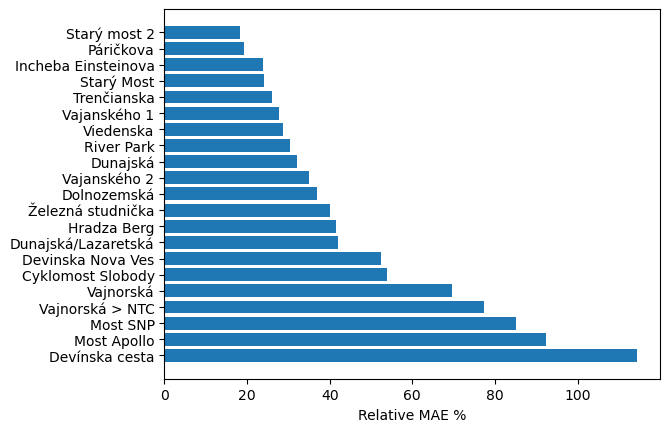

In [10]:
mae_rf = dict(sorted(mae_rf.items(), key=lambda x: x[1], reverse=True))

plt.barh(mae_rf.keys(), mae_rf.values())
plt.xlabel("Relative MAE %")